In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
from scipy.interpolate import interp1d

#### Load Example Data from KPLO Spacecraft 

In [2]:
"Load Data"
data = np.load("b_kplo.npy")

'Interpolate where 0 in z axis'
mask = data[0,0] == 0
if mask.any():
    # time-axis indices
    t = np.arange(data.shape[2])

    # the “good” times where data[0,0] is non-zero
    t_good = t[~mask]

    # the corresponding data at those times for all sensors/axes
    # shape (3,3,len(t_good))
    data_good = data[:,:,~mask]

    # build an interpolator along axis=2 (the sample axis)
    f = interp1d(
        t_good,
        data_good,
        axis=2,
        kind='linear',
        bounds_error=False,
        fill_value="extrapolate"    # extrapolate at ends if needed
    )

    # evaluate the interpolator at every t—including the masked ones
    data_filled = f(t)

    # overwrite only the masked entries in-place
    data[:,:,mask] = data_filled[:,:,mask]

In [3]:
B = data[:,0]
sample_rate = 1
print(B.shape)

(3, 86400)


In [4]:
fb = DyadicFilterBank(wavelet=Cauchy(1000), fs=sample_rate, N=50000, real=True, s_max = 30, dj = 1/18)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
)

In [5]:
transform.channel_freqs[0]

0.03372

Text(0.5, 0, 'Frequency Channel')

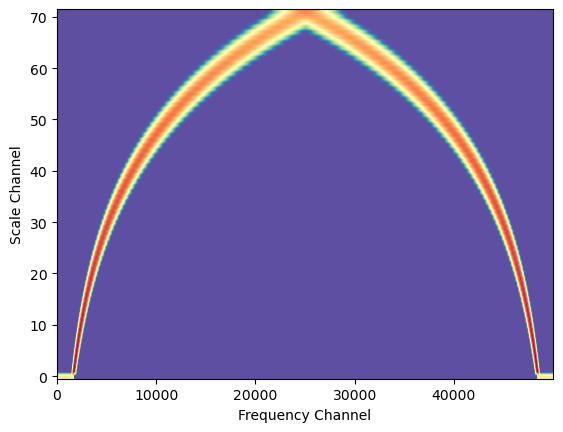

In [6]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

In [7]:
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])
w3 = transform.forward(B[2])

In [8]:
def mvdr_ambient(w1, w2, w3, reg_factor=1e-3, win_len=None):
    """
    MVDR (minimum-variance, distortionless) ambient-field estimator.

    Parameters
    ----------
    w1, w2, w3 : ndarray, shape (J, T)
        Complex wavelet coefficients from the three sensors.
        axis 0 = scale, axis 1 = time sample.
    reg_factor : float, optional
        Diagonal-loading factor λ.  Effective loading is
        λ · trace(R) · I_3   (default 1e-3).
    win_len : int or None
        If set, covariance is averaged over sliding windows of this length
        (in samples).  None ⇒ use the full time span per scale.

    Returns
    -------
    X_mvdr : ndarray, shape (J, T)
        Ambient-field estimate.
    K12, K13 : ndarray, shape (J,)
        Estimated gain ratios, useful for diagnostics.
    """
    w1 = np.asarray(w1); w2 = np.asarray(w2); w3 = np.asarray(w3)
    if not (w1.shape == w2.shape == w3.shape):
        raise ValueError("All w-arrays must have identical (J, T) shape")

    J, T = w1.shape

    # ------------------------------------------------------------------
    # 1) gain ratios  (least-squares over the *full* time axis)
    # ------------------------------------------------------------------
    denom = np.sum(np.abs(w1)**2, axis=1)            # (J,)
    # add tiny ε to avoid /0 when a scale is totally silent
    eps   = np.finfo(float).eps * denom.max()
    K12   = np.sum(w2 * w1.conj(), axis=1) / (denom + eps)
    K13   = np.sum(w3 * w1.conj(), axis=1) / (denom + eps)

    # steering vector g  (J, 3)  — phase is irrelevant
    g = np.stack([np.ones(J), K12, K13], axis=1)

    # normalize each row of g (helps numerical stability, not mandatory)
    g /= np.linalg.norm(g, axis=1, keepdims=True)

    # ------------------------------------------------------------------
    # 2) stack sensors for einsum convenience:  W[j,k,t]
    # ------------------------------------------------------------------
    W = np.stack([w1, w2, w3], axis=1)               # (J, 3, T)

    # helper: compute covariance R_j for every scale
    def covariance_full():
        return np.einsum('jkt,jlt->jkl', W, W.conj()) / T   # (J,3,3)

    def covariance_windowed():
        R = np.empty((J, 3, 3), W.dtype)
        half = win_len // 2
        for t in range(T):
            t0 = max(0, t - half)
            t1 = min(T, t + half + 1)
            Ww = W[:, :, t0:t1]
            R[:] += np.einsum('jkt,jlt->jkl', Ww, Ww.conj())
        return R / win_len

    R = covariance_full() if (win_len is None or win_len >= T) else covariance_windowed()

    # ------------------------------------------------------------------
    # 3) MVDR weights and ambient projection  (loop J to keep code clear)
    # ------------------------------------------------------------------
    X_mvdr = np.empty((J, T), W.dtype)

    I3 = np.eye(3, dtype=W.dtype)
    for j in range(J):
        Rj = R[j]
        # diagonal loading  λ·trace(R)·I
        Rj += reg_factor * np.trace(Rj).real * I3

        # w_mvdr = R^-1 g / (g^H R^-1 g)
        try:
            Rinv_g = np.linalg.solve(Rj, g[j])          # 3×1
        except np.linalg.LinAlgError:                   # ill-conditioned
            Rinv_g = np.linalg.pinv(Rj) @ g[j]

        denom = g[j].conj() @ Rinv_g
        wj    = Rinv_g / denom

        # X = w^H · W
        X_mvdr[j] = np.einsum('k,kT->T', wj.conj(), W[j])

    return X_mvdr

#X_mvdr = mvdr_ambient(w1, w2, w3, reg_factor=1e-3, win_len=None)

In [9]:
def WAICUP(w1, w2):
    D = w2 - w1  # shape (J, T), complex

    # 1) correlations (eqs 6–7), using conjugate inner products
    C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
    C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

    # 2) gain estimate K̂ per scale (eq 8)
    K_hat = C2 / C1                          # shape (J,)
    # (optionally force to real if you know K is real:)
    K_hat = K_hat

    # 4) ambient‑field estimate X(s,τ) (eq 10)
    X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 
    return X

X1 = WAICUP(w1, w2)
X2 = WAICUP(w1, w3)
X3 = WAICUP(w2, w3)
X_min = np.minimum.reduce([X1, X2, X3])

In [10]:
X_min = np.minimum.reduce([X1, X2, X3])

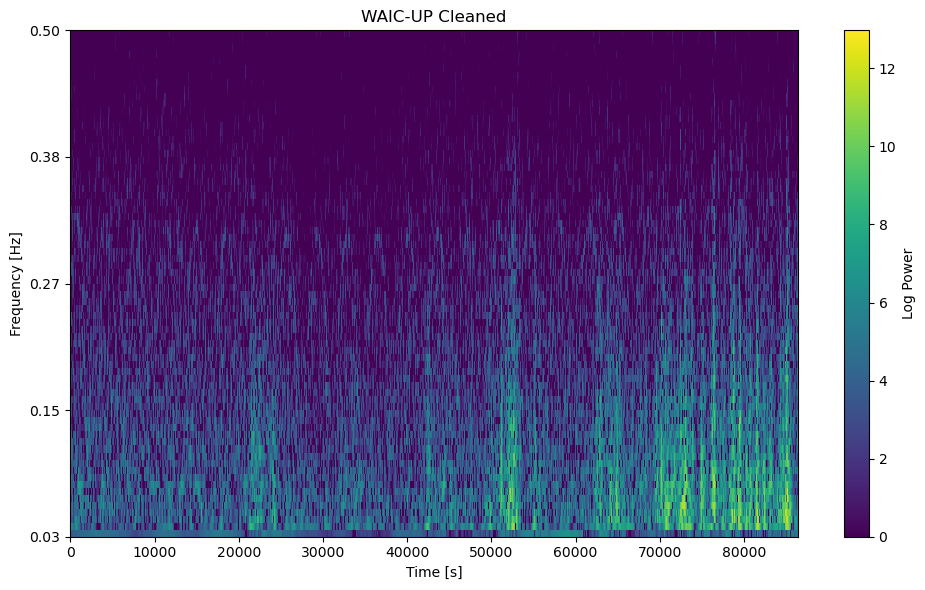

In [11]:
transform.scalogram(X_min, vmin=0,  title = 'WAIC-UP Cleaned')

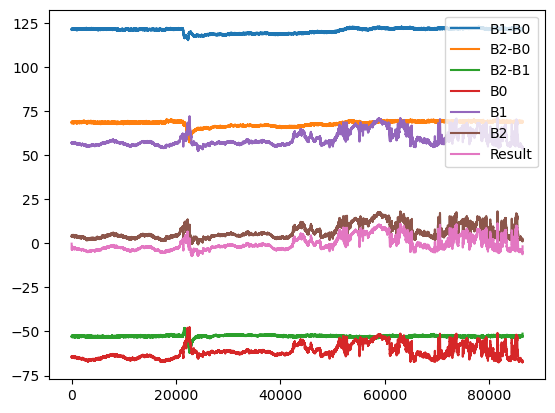

In [14]:
result = transform.inverse(np.copy(X_min))
plt.plot(B[1]- B[0], label = 'B1-B0')
plt.plot(B[2]- B[0], label = 'B2-B0')
plt.plot(B[2]- B[1], label = 'B2-B1')
plt.plot(B[0], label = 'B0')
plt.plot(B[1], label = 'B1')
plt.plot(B[2], label = 'B2')
plt.plot(result, label = 'Result')
plt.legend()

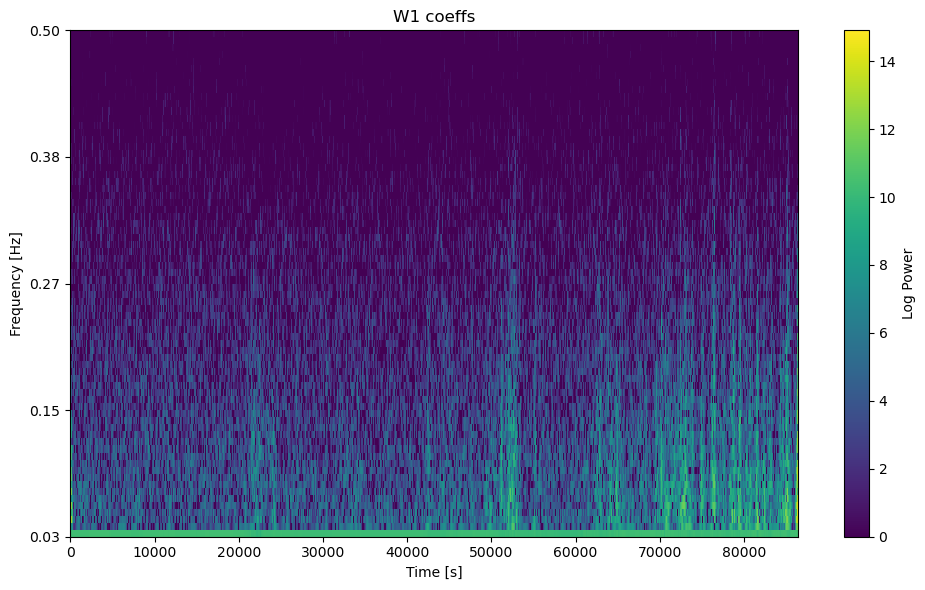

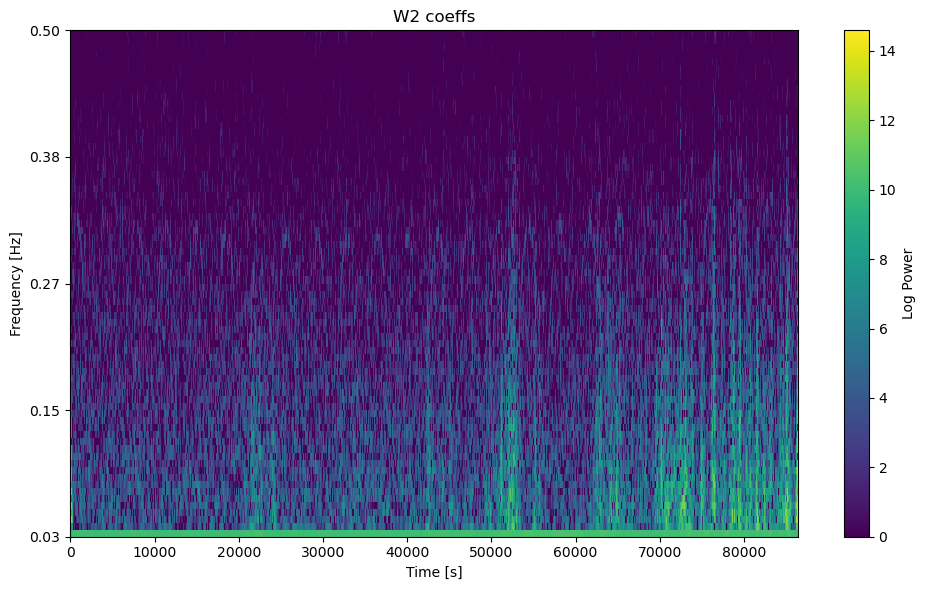

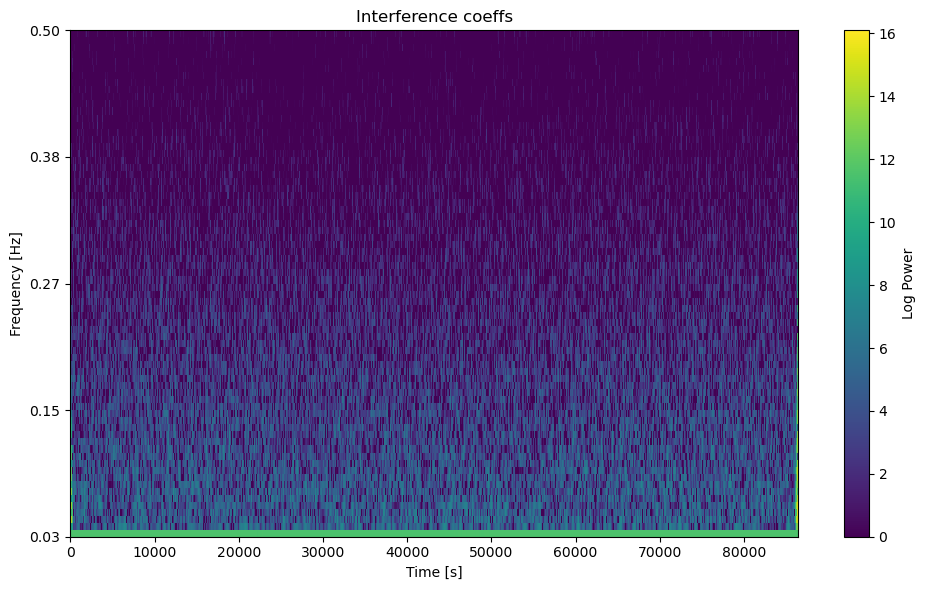

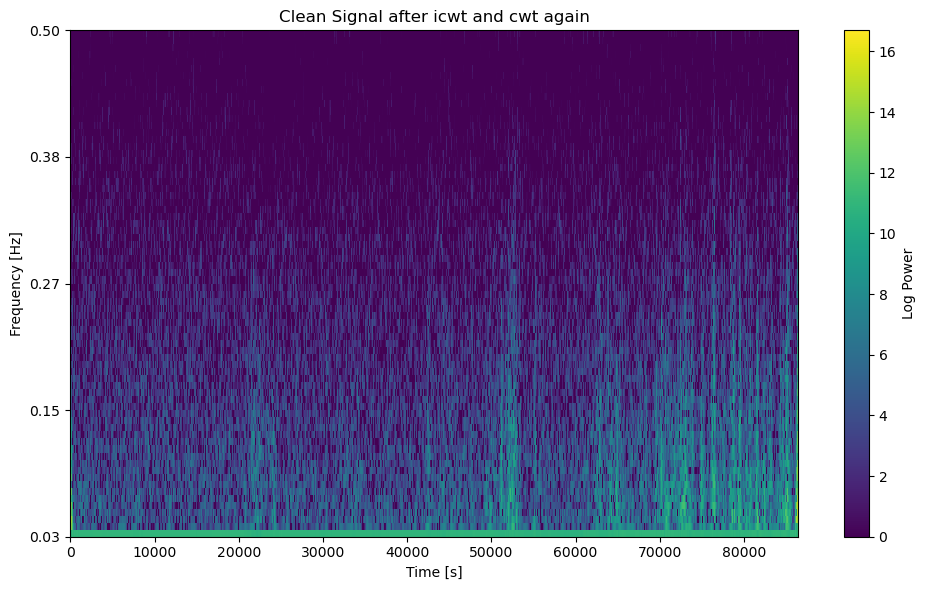

In [83]:
transform.scalogram(w1, vmin=0,  title = 'W1 coeffs')
transform.scalogram(w2, vmin=0, title = 'W2 coeffs')
interference = transform.forward(B[1]-B[0])
transform.scalogram(interference, vmin=0, title = 'Interference coeffs')
w = transform.forward(result)
transform.scalogram(w, vmin=0, title = 'Clean Signal after icwt and cwt again')

'\nThis chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? \n'

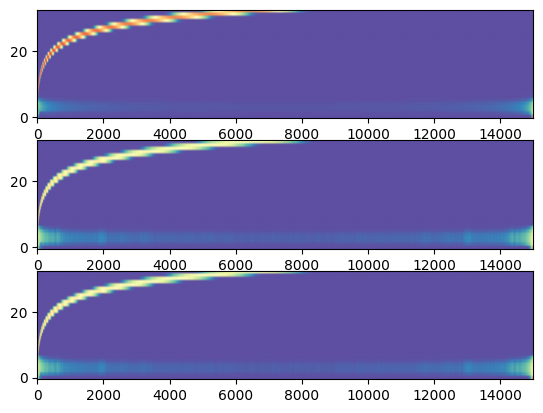

In [20]:
# https://www.sciencedirect.com/science/article/abs/pii/S0888327002915244 Aliasing??
fig, ax = plt.subplots(3,1)
ax[0].imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[1].imshow(np.log(np.abs(np.fft.fft(w_clean, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[2].imshow(np.log(np.abs(np.fft.fft(w1, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')


"""
This chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? 
"""

In [5]:
transform.b

1

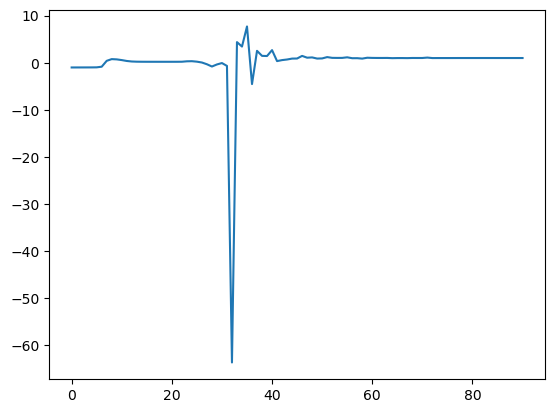

In [6]:

from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)

#### WAICUP


(2.3926963860090864+0j)


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


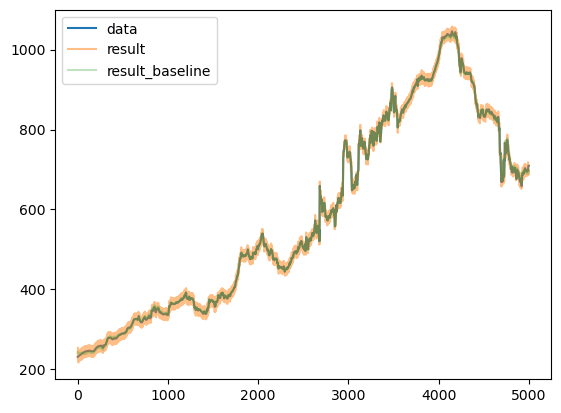

In [35]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend =True
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result', alpha=0.5)
plt.plot(result_baseline, label='result_baseline', alpha=0.3)
plt.legend()

In [8]:
1/6.10351562e-03



163.84000013421775